In [2]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import albumentations as A

In [3]:
#count the number of images in the data directory
def count_images(data_dir):
    images = [f for f in os.listdir(data_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
    return len(images)

data_dir_train = 'data_aug/train/images'
data_dir_test = 'data_aug/test/images'
data_dir_val = 'data_aug/valid/images'
print(f'train: {count_images(data_dir_train)}')
print(f'test: {count_images(data_dir_test)}')
print(f'valid: {count_images(data_dir_val)}')


train: 3272
test: 231
valid: 491


train: 1,636
test: 231
vail: 491

train 7,
test 1,
valid 2,
total 10


Augmentation Train


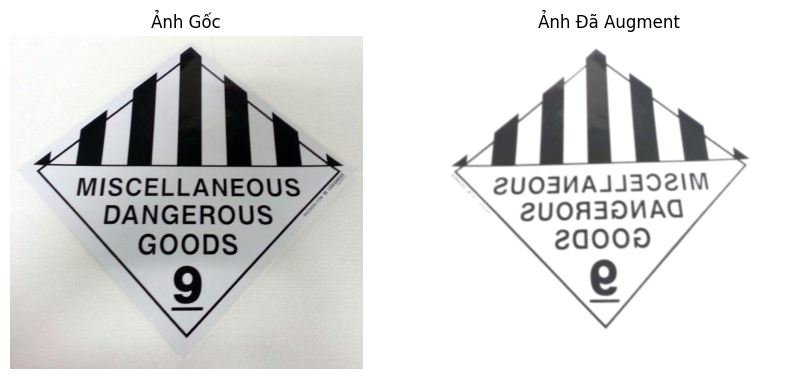

In [38]:
transform = A.Compose([
    # A.RandomCrop(width=256, height=256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=20, p=1),
    A.GaussianBlur(blur_limit=(3, 7), p=1),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=1),
])

image = cv2.imread("Hazmat Placards.v1i.yolov11/train/images/0c93c378e8_jpg.rf.adb3ef1a8039aff9909d9bd00101e18c.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

transformed = transform(image=image)
transformed_image = transformed["image"]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Ảnh Gốc')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(transformed_image)
plt.title('Ảnh Đã Augment')
plt.axis('off')

plt.show()

In [20]:
class_names = [
    '1 Explosives',
    '1-1 Explosives Products with the potential to create a mass explosion',
    '1-2 Explosives Products with the potential to create a projectile hazard',
    '1-3 Explosives Products with the potential to create a fire or minor blast',
    '1-4 Explosives Products with no significant risk of creating a blast',
    '1-5 Explosives Products considered very insensitive that are used as blasting agents',
    '1-6 Explosives Products considered extremely insensitive with no risk to create a mass explosion',
    '2 Oxygen',
    '2-1 Flammable gases',
    '2-2 Nonflammable gases',
    '2-3 Toxic gases',
    '3 Combustible',
    '3 Flammable',
    '3 Flammable and combustible liquids',
    '3 Flammable liquid',
    '4-1 Flammable solids',
    '4-2 Spontaneously combustible',
    '4-3 Dangerous when wet',
    '5-1 Oxidizing substances',
    '5-2 Organic peroxides',
    '6 Poisons',
    '7 Radioactive',
    '8 Corrosive',
    '9 Miscellaneous',
    'Dangerous',
    'Environmentally Hazardous Substance',
    'Hot',
    'Infectious Substance',
    'Orange Panel',
    'Placards',
    'Spontaneously combustible material',
    'license plate'
]

Visualize data augmentation

['23 0.49925031565656564 0.5061309324866309 0.916863952020202 0.901744930926916\n']


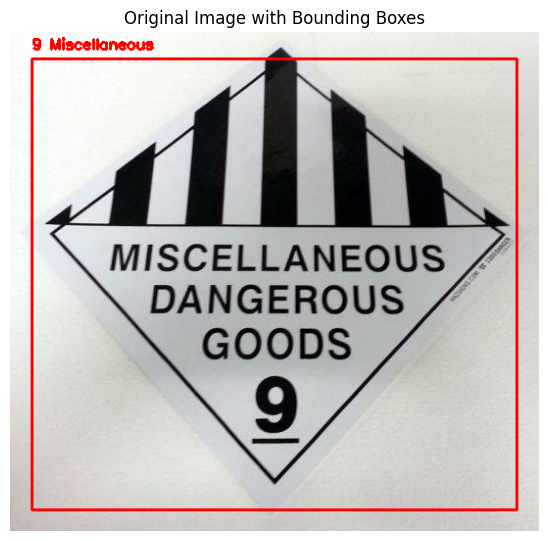

Original bounding boxes: [[0.49925031565656564, 0.5061309324866309, 0.916863952020202, 0.901744930926916]]
Augmented bounding boxes: [[0.4792290925979614, 0.5, 0.9584581851959229, 1.0], [0.9793305397033691, 0.5064115524291992, 0.041338883340358734, 0.9871768951416016]]
Class Labels: ['9 Miscellaneous']


In [82]:
def clip_bboxes(bbox, min_value=0, max_value=1):
    return [max(min(coord, max_value), min_value) for coord in bbox]

transform = A.Compose([
    A.HorizontalFlip(p=0.6),
    A.RandomBrightnessContrast(p=0.6),
    A.Rotate(limit=40, p=0.8),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=20, p=1),
    A.GaussianBlur(blur_limit=(3, 7), p=1),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=1),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

image = cv2.imread('data_aug/train/images/0c93c378e8_jpg.rf.adb3ef1a8039aff9909d9bd00101e18c.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

with open('data_aug/train/labels/0c93c378e8_jpg.rf.adb3ef1a8039aff9909d9bd00101e18c.txt', 'r') as f:
    lines = f.readlines()

print(lines)

bboxes = []
class_labels = []

for line in lines:
    values = line.strip().split()[:5]  
    class_id, x_center, y_center, bbox_width, bbox_height = map(float, values)
    
    bboxes.append([x_center, y_center, bbox_width, bbox_height])
    class_labels.append(class_names[int(class_id)])


bboxes = [clip_bboxes(bbox) for bbox in bboxes]

augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
augmented_image = augmented['image']
augmented_bboxes = [clip_bboxes(bbox) for bbox in augmented['bboxes']]

def draw_bboxes(image, bboxes, class_labels=None):
    for i, bbox in enumerate(bboxes):
        x_center, y_center, bbox_width, bbox_height = bbox
        x1 = int((x_center - bbox_width / 2) * image.shape[1])
        y1 = int((y_center - bbox_height / 2) * image.shape[0])
        x2 = int((x_center + bbox_width / 2) * image.shape[1])
        y2 = int((y_center + bbox_height / 2) * image.shape[0])
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
        if class_labels and i < len(class_labels):
            cv2.putText(image, class_labels[i], (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

original_image_with_bbox = image.copy()
draw_bboxes(original_image_with_bbox, bboxes, class_labels)

augmented_image_with_bbox = augmented_image.copy()
draw_bboxes(augmented_image_with_bbox, augmented_bboxes, augmented['class_labels'])

plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.imshow(original_image_with_bbox)
plt.title('Original Image with Bounding Boxes')
plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.imshow(augmented_image_with_bbox)
# plt.title('Augmented Image with New Bounding Boxes')
# plt.axis('off')

plt.show()

print("Original bounding boxes:", bboxes)
print("Augmented bounding boxes:", augmented_bboxes)
print("Class Labels:", class_labels)


Augmentation 

In [79]:
source_image_folder = 'Hazmat Placards.v1i.yolov11/train/images'
source_label_folder = 'Hazmat Placards.v1i.yolov11/train/labels'
aug_image_folder = 'data_aug/train/images'
aug_label_folder = 'data_aug/train/labels'

os.makedirs(aug_image_folder, exist_ok=True)
os.makedirs(aug_label_folder, exist_ok=True)

def clip_bboxes(bbox, min_value=0, max_value=1):
    return [max(min(coord, max_value), min_value) for coord in bbox]

transform = A.Compose([
    A.HorizontalFlip(p=1),
    A.RandomBrightnessContrast(p=1),
    A.Rotate(limit=40, p=1),
    # A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=20, p=1),
    A.GaussianBlur(blur_limit=(3, 7), p=1),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

for image_filename in os.listdir(source_image_folder):
    if image_filename.endswith('.jpg') or image_filename.endswith('.png'):  
        try:
            image_path = os.path.join(source_image_folder, image_filename)
            image = cv2.imread(image_path)
            if image is None:
                print(f"Warning: Unable to read image {image_filename}. Skipping.")
                continue  
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

            label_filename = image_filename.replace('.jpg', '.txt').replace('.png', '.txt')
            label_path = os.path.join(source_label_folder, label_filename)

            bboxes = []
            class_labels = []

            with open(label_path, 'r') as f:
                lines = f.readlines()

            for line in lines:
                values = line.strip().split() 
                class_id, x_center, y_center, bbox_width, bbox_height = map(float, values)

                bboxes.append([x_center, y_center, bbox_width, bbox_height])
                class_labels.append(int(class_id))  

            bboxes = [clip_bboxes(bbox) for bbox in bboxes]

            augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
            augmented_image = augmented['image']
            augmented_bboxes = [clip_bboxes(bbox) for bbox in augmented['bboxes']]
            
            original_output_path = os.path.join(aug_image_folder, image_filename)
            cv2.imwrite(original_output_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))  

            augmented_image_path = os.path.join(aug_image_folder, f'aug_{image_filename}')  
            cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR))

            original_label_path = os.path.join(aug_label_folder, label_filename)
            with open(original_label_path, 'w') as f:
                for bbox, class_id in zip(bboxes, class_labels):
                    f.write(f"{class_id} {bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]}\n")


            augmented_label_path = os.path.join(aug_label_folder, f'aug_{label_filename}') 
            with open(augmented_label_path, 'w') as f:
                for bbox, class_id in zip(augmented_bboxes, class_labels):
                    f.write(f"{class_id} {bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]}\n")

        except Exception as e:
            print(f"Error processing {image_filename}: {e}. Skipping.")

print("Augmentation completed and images and labels are saved.")


Error processing 35d16e7e67_jpg.rf.81e4449b76197cd1bd678af2fb8de770.jpg: Expected y_max for bbox [0.0000000e+00 1.6700029e-03 1.0000000e+00 1.0000100e+00 2.0000000e+00] to be in the range [0.0, 1.0], got 1.0000100135803223.. Skipping.
Error processing 540b67d94f_jpg.rf.58a911ae03f4daf49bf22b167eb97b15.jpg: Expected y_max for bbox [4.9999952e-03 1.6700029e-03 1.0000000e+00 1.0000100e+00 3.0000000e+00] to be in the range [0.0, 1.0], got 1.0000100135803223.. Skipping.


c:\Users\Admin\anaconda3\envs\hazardous_detection\lib\site-packages\albumentations\core\bbox_utils.py:476: RuntimeWarning: invalid value encountered in divide
  & (clipped_box_areas / denormalized_box_areas >= min_visibility - epsilon)


Error processing Truck185_jpg.rf.8d228959aff7c152dea0e58f83750c50.jpg: too many values to unpack (expected 5). Skipping.
Error processing Truck236_jpg.rf.a3ef0f1bca8edd4635ca2df1b44f3334.jpg: too many values to unpack (expected 5). Skipping.
Error processing Truck238_jpg.rf.16efad0afe281f1bbb31f17ce840708d.jpg: too many values to unpack (expected 5). Skipping.
Error processing Truck243_jpg.rf.fb9ca51a4b1a5a630998dc4c1c4a0f7e.jpg: too many values to unpack (expected 5). Skipping.
Error processing Truck282_jpg.rf.2ada5babe59ec87b8af1f8f0ac248b8f.jpg: too many values to unpack (expected 5). Skipping.
Error processing Truck357_jpg.rf.1bd7b9c0741f857351a2487d4e5775ec.jpg: too many values to unpack (expected 5). Skipping.
Augmentation completed and images and labels are saved.


Check label data

In [ ]:
image_folder = 'data_aug/train/images'  
label_folder = 'data_aug/train/labels'  

for image_filename in os.listdir(image_folder):
    if image_filename.endswith('.jpg') or image_filename.endswith('.png'):
        image_path = os.path.join(image_folder, image_filename)
        image = cv2.imread(image_path)
        if image is None:
            print(f"Warning: Unable to read image {image_filename}. Skipping.")
            continue 

        label_filename = image_filename.replace('.jpg', '.txt').replace('.png', '.txt')
        label_path = os.path.join(label_folder, label_filename)

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()

            for line in lines: 
                values = line.strip().split()
                print(values)
                try:
                    class_id = int(values[0])  
                    x_center, y_center, bbox_width, bbox_height = map(float, values[1:5])  
                    
                    if class_id < len(class_names):
                        class_name = class_names[class_id]
                        print(f"Class ID: {class_id}, Class Name: {class_name}")
                    else:
                        print(f"Error: Class ID {class_id} exceeds available class names. Skipping.")
                        continue 

                    img_height, img_width, _ = image.shape
                    x1 = int((x_center - bbox_width / 2) * img_width)
                    y1 = int((y_center - bbox_height / 2) * img_height)
                    x2 = int((x_center + bbox_width / 2) * img_width)
                    y2 = int((y_center + bbox_height / 2) * img_height)

                    cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2) 
                    label = f"Class {class_names[class_id]}"
                    cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

                except (ValueError, IndexError) as e:
                    print(f"Error processing line: {line.strip()}. Error: {e}")
                    continue

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(10, 10))
        plt.imshow(image_rgb)
        plt.axis('off') 
        plt.title(image_filename)
        plt.show()

['30', '0.5232950448989868', '0.3431418240070343', '0.27371281385421753', '0.5835057497024536']
Class ID: 30, Class Name: Spontaneously combustible material
['27', '0.21432316303253174', '0.7993171215057373', '0.23194178938865662', '0.3441840410232544']
Class ID: 27, Class Name: Infectious Substance
['27', '0.10347229242324829', '0.16328245401382446', '0.19596053659915924', '0.3265649080276489']
Class ID: 27, Class Name: Infectious Substance


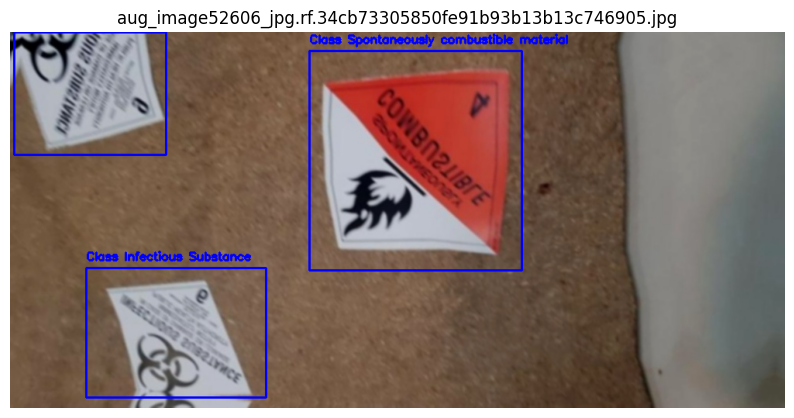

['7', '0.3187035620212555', '0.2755151391029358', '0.24343164265155792', '0.42041638493537903']
Class ID: 7, Class Name: 2 Oxygen
['5', '0.7906662821769714', '0.5833513140678406', '0.25067198276519775', '0.4174082279205322']
Class ID: 5, Class Name: 1-5 Explosives Products considered very insensitive that are used as blasting agents


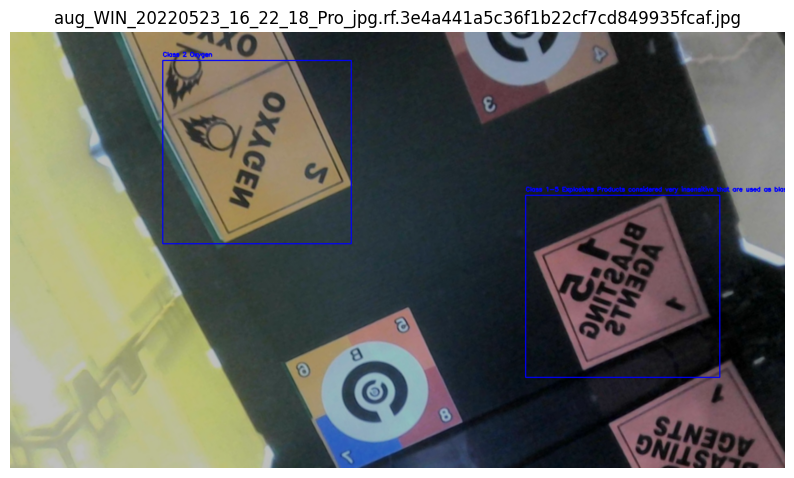

['31', '0.6048538088798523', '0.5064759850502014', '0.03264433145523071', '0.0181135106831789']
Class ID: 31, Class Name: license plate
['29', '0.547791063785553', '0.39347928762435913', '0.051873303949832916', '0.04443715140223503']
Class ID: 29, Class Name: Placards
['29', '0.5783920288085938', '0.41004329919815063', '0.05177602171897888', '0.04332297667860985']
Class ID: 29, Class Name: Placards
['29', '0.5544610619544983', '0.4337831437587738', '0.051315680146217346', '0.04009568318724632']
Class ID: 29, Class Name: Placards
['29', '0.5237829089164734', '0.41538986563682556', '0.051793552935123444', '0.043149445205926895']
Class ID: 29, Class Name: Placards


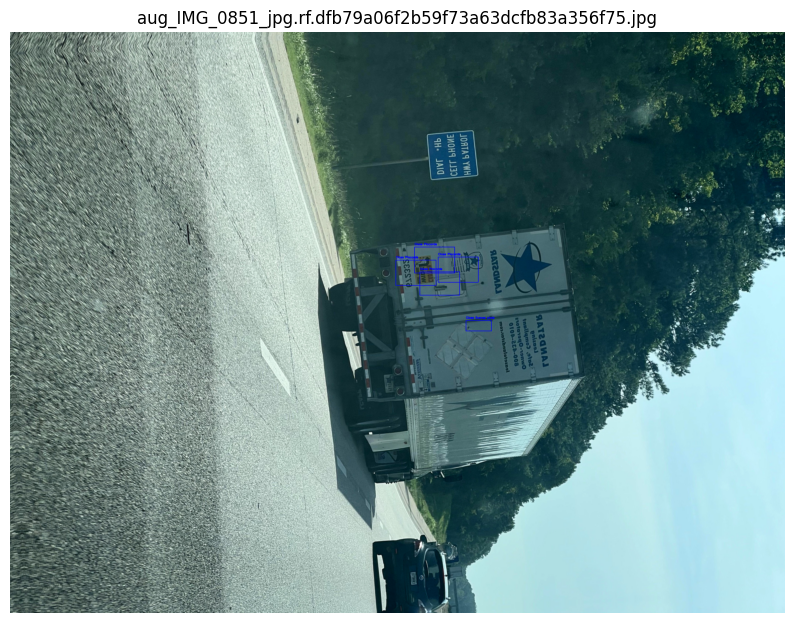

['8', '0.5', '0.5', '1.0', '1.0']
Class ID: 8, Class Name: 2-1 Flammable gases


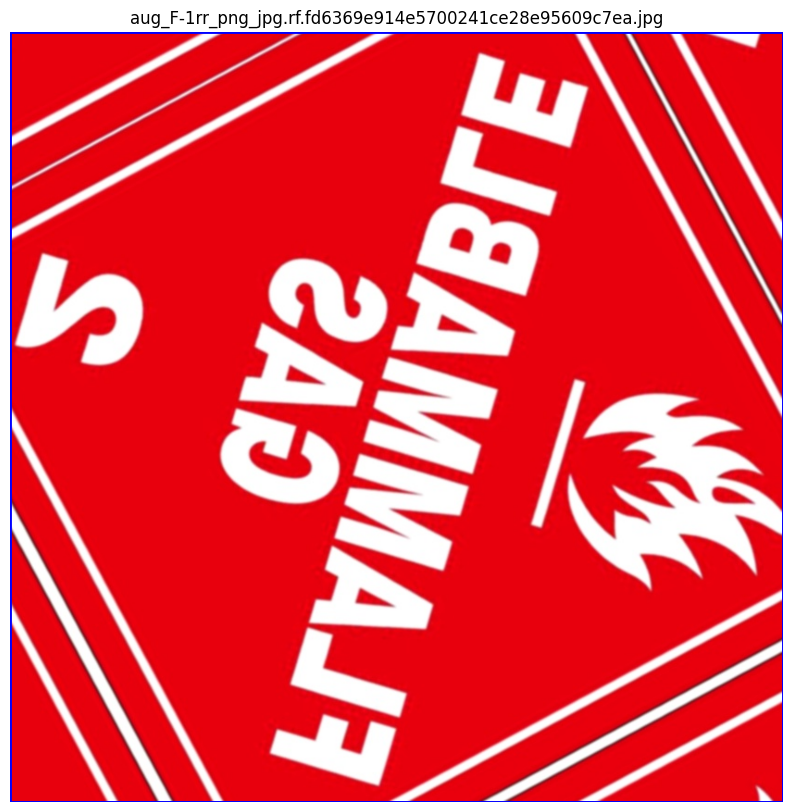

['2', '0.4930303692817688', '0.3211211562156677', '0.1558506339788437', '0.21987955272197723']
Class ID: 2, Class Name: 1-2 Explosives Products with the potential to create a projectile hazard
['30', '0.5212022662162781', '0.666958212852478', '0.1520754098892212', '0.21264991164207458']
Class ID: 30, Class Name: Spontaneously combustible material


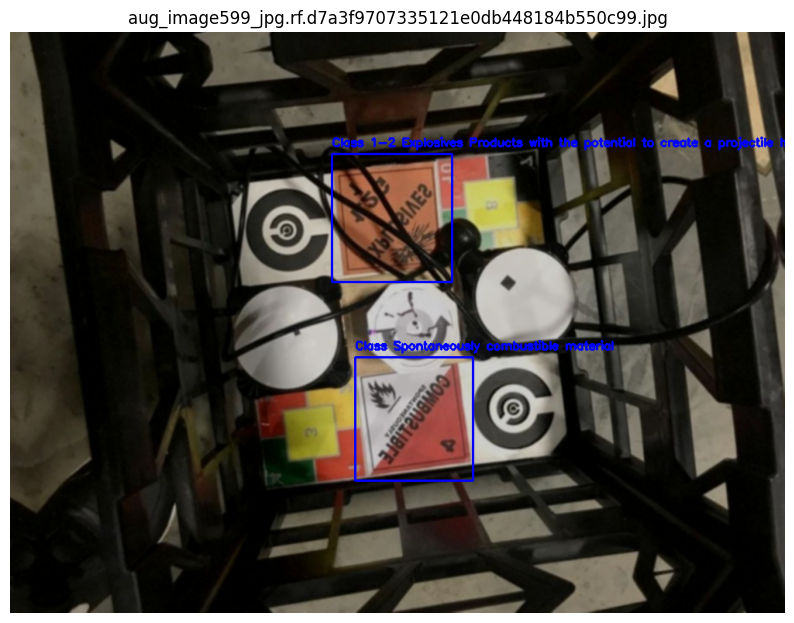

['18', '0.2921875', '0.428125', '0.190625', '0.178125']
Class ID: 18, Class Name: 5-1 Oxidizing substances
['7', '0.51953125', '0.64453125', '0.1765625', '0.1765625']
Class ID: 7, Class Name: 2 Oxygen


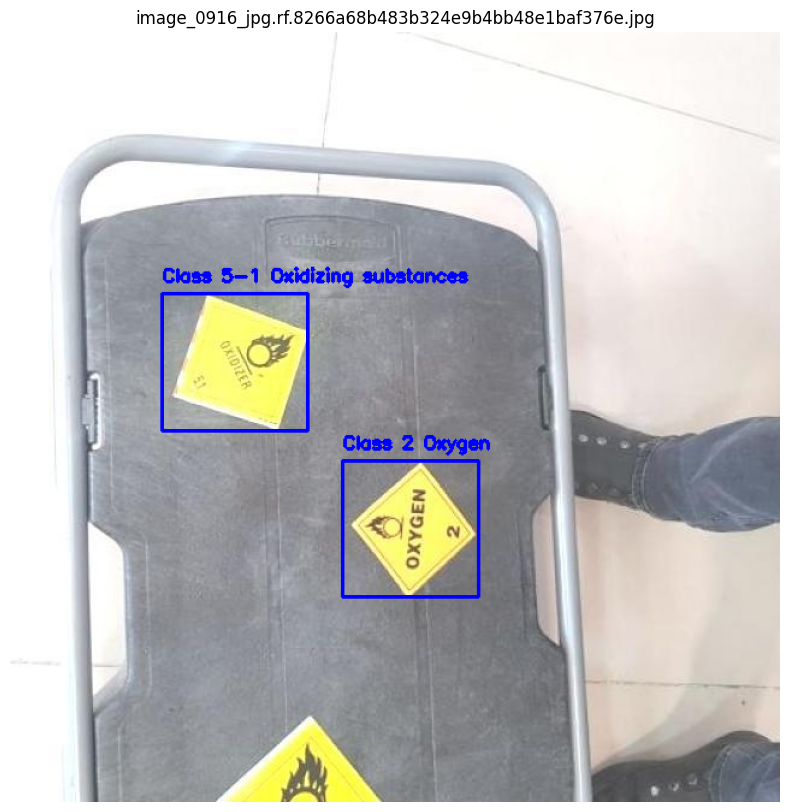

['17', '0.3835051546391753', '0.5195', '0.23917525773195877', '0.115']
Class ID: 17, Class Name: 4-3 Dangerous when wet
['17', '0.8360824742268042', '0.099', '0.17938144329896907', '0.084']
Class ID: 17, Class Name: 4-3 Dangerous when wet


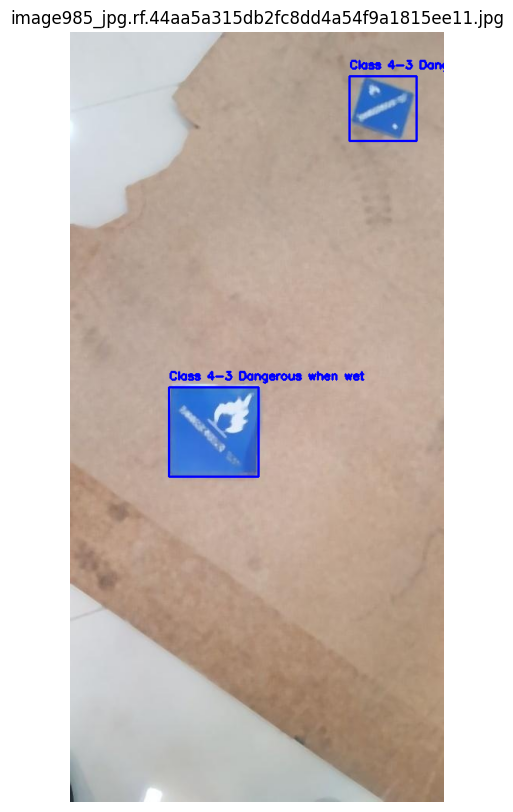

['20', '0.43427835051546393', '0.5182692307692308', '0.19329896907216496', '0.14423076923076922']
Class ID: 20, Class Name: 6 Poisons


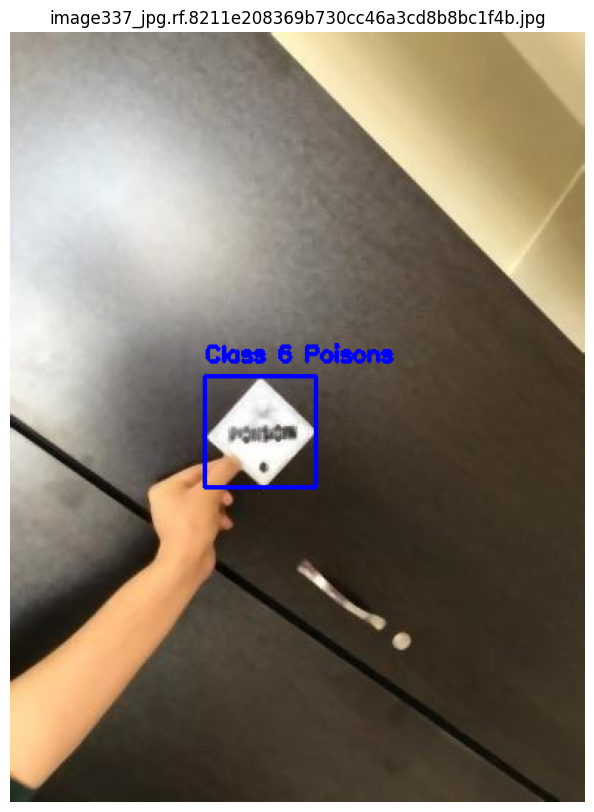

['13', '0.2861962733524187', '0.5124113600894085', '0.42148947715759283', '0.6335690357122419']
Class ID: 13, Class Name: 3 Flammable and combustible liquids
['25', '0.7204140084130425', '0.4893548028248258', '0.41683248111179916', '0.621779157877093']
Class ID: 25, Class Name: Environmentally Hazardous Substance


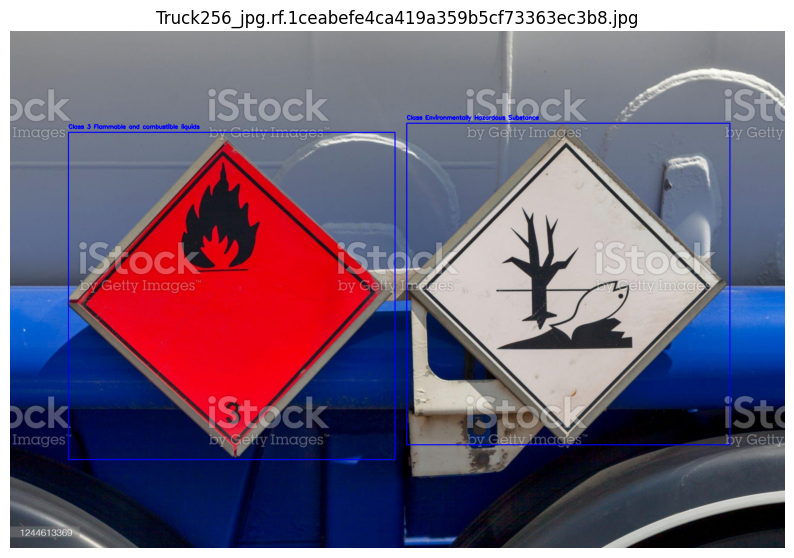

['22', '0.616', '0.6268041237113402', '0.3', '0.5030927835051546']
Class ID: 22, Class Name: 8 Corrosive
['27', '0.1285', '0.7051546391752578', '0.257', '0.41649484536082476']
Class ID: 27, Class Name: Infectious Substance
['2', '0.505', '0.08453608247422681', '0.2', '0.16907216494845362']
Class ID: 2, Class Name: 1-2 Explosives Products with the potential to create a projectile hazard
['30', '0.1485', '0.1268041237113402', '0.197', '0.23711340206185566']
Class ID: 30, Class Name: Spontaneously combustible material


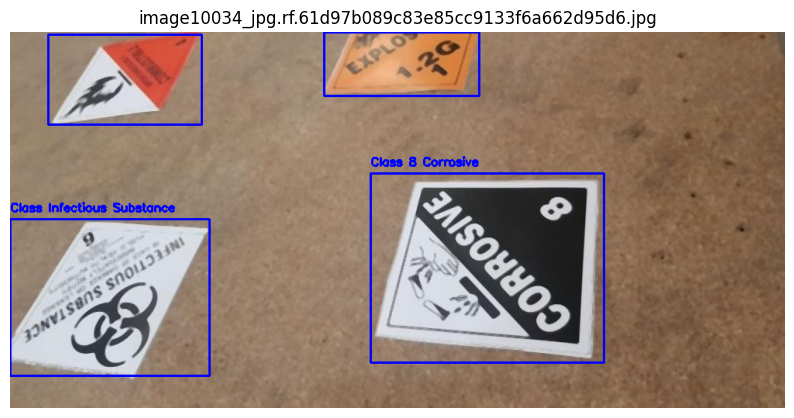

In [84]:
import random

image_folder = 'data_aug/train/images'  
label_folder = 'data_aug/train/labels'

image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg') or f.endswith('.png')]

sampled_files = random.sample(image_files, min(10, len(image_files)))

for image_filename in sampled_files:
    image_path = os.path.join(image_folder, image_filename)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Unable to read image {image_filename}. Skipping.")
        continue

    label_filename = image_filename.replace('.jpg', '.txt').replace('.png', '.txt')
    label_path = os.path.join(label_folder, label_filename)

    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            lines = f.readlines()

        for line in lines: 
            values = line.strip().split()  
            print(values)
            try:
                class_id = int(values[0])  
                x_center, y_center, bbox_width, bbox_height = map(float, values[1:5])  
                
                if class_id < len(class_names):
                    class_name = class_names[class_id]
                    print(f"Class ID: {class_id}, Class Name: {class_name}")
                else:
                    print(f"Error: Class ID {class_id} exceeds available class names. Skipping.")
                    continue

                img_height, img_width, _ = image.shape
                x1 = int((x_center - bbox_width / 2) * img_width)
                y1 = int((y_center - bbox_height / 2) * img_height)
                x2 = int((x_center + bbox_width / 2) * img_width)
                y2 = int((y_center + bbox_height / 2) * img_height)

                cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2) 
                label = f"Class {class_names[class_id]}"
                cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

            except (ValueError, IndexError) as e:
                print(f"Error processing line: {line.strip()}. Error: {e}")
                continue

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.axis('off') 
    plt.title(image_filename)
    plt.show()


Add noise bouding box

In [74]:
def add_noise_to_bboxes(image, bboxes):
    for bbox in bboxes:
        x1, y1, x2, y2 = bbox 

        bbox_region = image[y1:y2, x1:x2]

        noise = np.random.normal(0, 0.5, bbox_region.shape).astype(np.uint8) 
        noisy_bbox_region = cv2.add(bbox_region, noise)

        image[y1:y2, x1:x2] = noisy_bbox_region
    
    return image


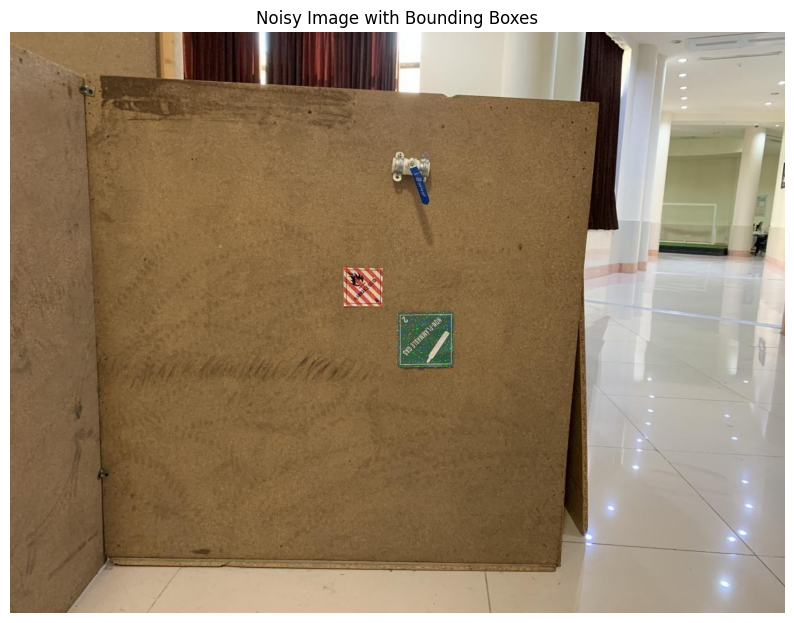

In [75]:
image = cv2.imread('data_aug/train/images/06_jpg.rf.1c5b980cde463430f9068ff8e67e9972.jpg')

bboxes = [
    [0.5359375, 0.5307291666666667, 0.0734375, 0.09895833333333333],
    [0.45546875, 0.4401041666666667, 0.0515625, 0.06770833333333333],
]

img_height, img_width, _ = image.shape
pixel_bboxes = [
    [
        int((x_center - bbox_width / 2) * img_width),
        int((y_center - bbox_height / 2) * img_height),
        int((x_center + bbox_width / 2) * img_width),
        int((y_center + bbox_height / 2) * img_height)
    ]
    for x_center, y_center, bbox_width, bbox_height in bboxes
]

noisy_image = add_noise_to_bboxes(image, pixel_bboxes)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(noisy_image, cv2.COLOR_BGR2RGB))
plt.axis('off')  
plt.title('Noisy Image with Bounding Boxes')
plt.show()
